<a href="https://colab.research.google.com/github/makafanpeter/CS4740-Techblog/blob/main/Music_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Convolutional Neural Network (CNN) Approach to Music Genre Classification
## Background
Music is becoming easier to access through the internet and musical apps like Spotify and Apple Music. With the escalating number of music available digitally on the internet, there is a growing demand for the systematic organization of audio files and thus a rise in the interest in automatic music genre classification. Moreover, detecting and grouping music of a similar genre is a keen part of the music recommendation system and playlist that are personalized to both your mood and your unique music taste.

Before assigning this task to a computer it would mean a great deal to understand how a person would carry out a similar task of classifying music into different genres, However, musical content is complex and music genres are not well defined.

How can a computer automatically classify sound-based genre? It turns out that classifying music into different genres would be considered a very challenging task for a computer due to the selection and extraction of appropriate audio features. Music genre classification is composed of two basic steps: feature extraction and classification. In the first stage, various features are extracted from the waveform. In the second stage, a classifier is built using the features extracted from the training data. In this blog post, we will walk through building a deep learning model for classifying music into different genres using the gtzan dataset. We will walk through how to train a model, design the input and output for genre classifications, and finally display the accuracy results for the model.

## Software Requirements

- Python 
- Numpy
- Matplotlib
- Scikit-learn
- Scikit-plot
- Keras
- Tensorflow
- Kapre
- Librosa
- pydub


In [ ]:
%tensorflow_version 1.x
!pip install pydub


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.initializers import glorot_uniform
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
from keras.preprocessing.image import ImageDataGenerator
import random
import time
import io
print(tf.__version__)

1.15.2


# Gtzan Dataset
The gtzan8 audio dataset contains 1000 tracks of 30 second length. There are 10 genres, each containing 100 tracks which are all 22050Hz Mono 16-bit audio files in .wav format. The genres are:

The GTZAN Music Genre Dataset, which is a collection of 1000 songs in 10 genres, is the most widely used dataset.

Although many studies have been conducted using GTZAN, several faults have been pointed out. Sturm[1], for example, identified and analysed the contents of GTZAN and provided a catalogue of its faults. As it is the most used dataset, however, the system performance of MGC in this project should first be evaluated with GTZAN in order to compare against other systems used in other studies.

Details on the GTZAN Music Genre Dataset are presented in the table below. In GTZAN, each song is recorded at a sampling rate of 22.05 kHz and mono 16-bit audio files in .wav format.

* blues
* classical
* country
* disco
* hiphop
* jazz
* metal
* pop
* reggae
* rock

In [ ]:
!echo "Downloading Dataset..."
!curl -LO http://opihi.cs.uvic.ca/sound/genres.tar.gz
!tar -zxvf genres.tar.gz
!mv genres data
!echo "Dataset Downloaded"

!echo "Start Converting audio file format..."
!for genre in data/*; do
!    for filename in $genre/*; do
!        sox $filename "$filename.wav";
!        rm $filename;
!    done
!done
!echo "Converted au to wav"
!rm -r genres.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1168M  100 1168M    0     0  1806k      0  0:11:02  0:11:02 --:--:-- 1855k
genres/
genres/bextract_single.mf
genres/bl.mf
genres/blues/
genres/cl.mf
genres/classical/
genres/co.mf
genres/country/
genres/di.mf
genres/disco/
genres/hi.mf
genres/hiphop/
genres/input.mf
genres/ja.mf
genres/jazz/
genres/me.mf
genres/metal/
genres/po.mf
genres/pop/
genres/re.mf
genres/reggae/
genres/ro.mf
genres/rock/
genres/rock/rock.00000.wav
genres/rock/rock.00001.wav
genres/rock/rock.00002.wav
genres/rock/rock.00003.wav
genres/rock/rock.00004.wav
genres/rock/rock.00005.wav
genres/rock/rock.00006.wav
genres/rock/rock.00007.wav
genres/rock/rock.00008.wav
genres/rock/rock.00009.wav
genres/rock/rock.00010.wav
genres/rock/rock.00011.wav
genres/rock/rock.00012.wav
genres/rock/rock.00013.wav
genres/rock/rock.00014.wav
genres/rock/rock.00015.wav
genres/

In [ ]:
drive_path = '/content/g-drive'
from google.colab import drive
drive.mount(drive_path,force_remount=True)

Mounted at /content/g-drive


In [ ]:
# Source path 
source = '/content/data'

  
# home path 
home_path = '/MyDrive/Music-Clasification'
destination = drive_path + home_path

if not os.path.exists(destination):  
     os.makedirs(destination)
     dest = shutil.move(source, destination)
else:
    print (destination + " Already exists!") 


/content/g-drive/MyDrive/Music-Clasification Already exists!


In [ ]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        count = 0
        for f in files:
          count = count + 1
        print('{}{}'.format(subindent, count))
          


list_files(destination + '/data')

data/
    12
    rock/
        100
    reggae/
        100
    pop/
        100
    metal/
        100
    jazz/
        100
    hiphop/
        100
    disco/
        100
    country/
        100
    classical/
        100
    blues/
        100


In [ ]:
path =  destination + "/spectrograms3sec"
if not os.path.exists(path):  
     os.makedirs(path)
else:
    print (path + " Already exists!")

path = destination +"/time_domain"
if not os.path.exists(path):  
     os.makedirs(path)
else:
    print (path + " Already exists!")

path = destination +"/power_spectrograms"
if not os.path.exists(path):  
     os.makedirs(path)
else:
    print (path + " Already exists!")


/content/g-drive/MyDrive/Music-Clasification/spectrograms3sec Already exists!
/content/g-drive/MyDrive/Music-Clasification/time_domain Already exists!
/content/g-drive/MyDrive/Music-Clasification/power_spectrograms Already exists!


In [ ]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = sorted(genres.split())

In [ ]:

for g in genres:
  path1 = os.path.join(destination +'/audio3sec',f'{g}')
  if not os.path.exists(path1):  
     os.makedirs(path1)
  else:
     print (path1 + " Already exists!")

  path = os.path.join(destination + '/spectrograms3sec',f'{g}')
  if not os.path.exists(path):  
     os.makedirs(path)
  else:
    print (path + " Already exists!")

  path = os.path.join(destination + 'spectrograms3sec',f'{g}')
  if not os.path.exists(path):  
     os.makedirs(path)
  else:
    print (path + " Already exists!")


music_library = destination + '/data'

/content/g-drive/MyDrive/Music-Clasification/audio3sec/blues Already exists!
/content/g-drive/MyDrive/Music-Clasification/spectrograms3sec/blues Already exists!
/content/g-drive/MyDrive/Music-Clasificationspectrograms3sec/blues Already exists!
/content/g-drive/MyDrive/Music-Clasification/audio3sec/classical Already exists!
/content/g-drive/MyDrive/Music-Clasification/spectrograms3sec/classical Already exists!
/content/g-drive/MyDrive/Music-Clasificationspectrograms3sec/classical Already exists!
/content/g-drive/MyDrive/Music-Clasification/audio3sec/country Already exists!
/content/g-drive/MyDrive/Music-Clasification/spectrograms3sec/country Already exists!
/content/g-drive/MyDrive/Music-Clasificationspectrograms3sec/country Already exists!
/content/g-drive/MyDrive/Music-Clasification/audio3sec/disco Already exists!
/content/g-drive/MyDrive/Music-Clasification/spectrograms3sec/disco Already exists!
/content/g-drive/MyDrive/Music-Clasificationspectrograms3sec/disco Already exists!
/conte

## Feature Extraction

In this project, 2 types of audio features are extracted.

* Low-level audio feature
* Mel-spectrogram

### Low-level audio feature

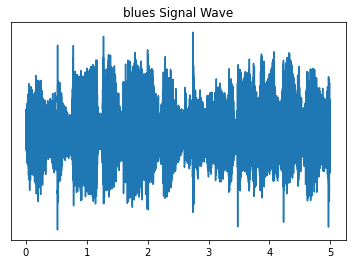

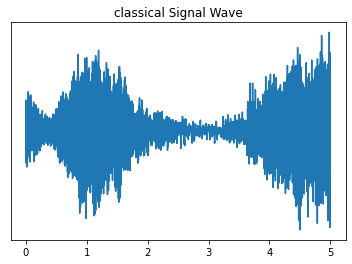

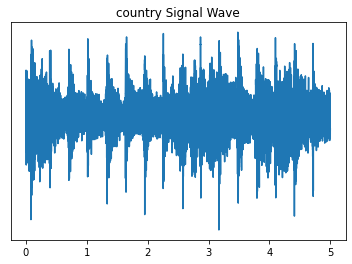

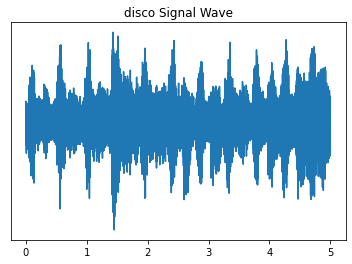

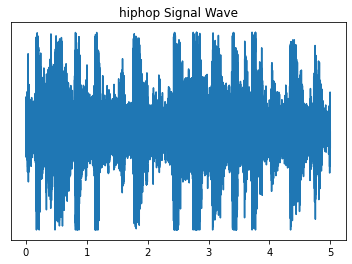

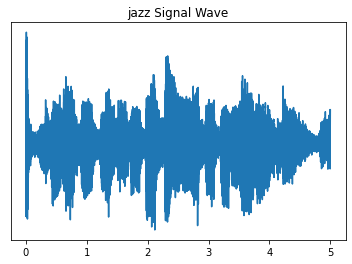

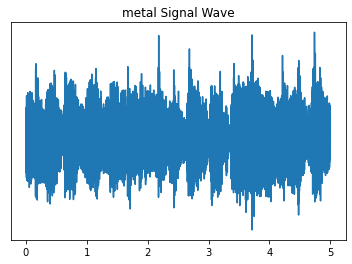

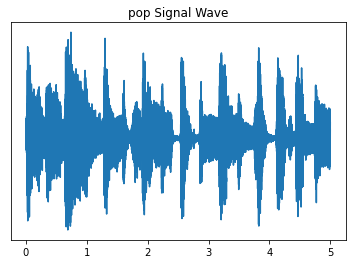

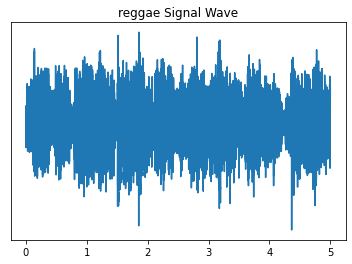

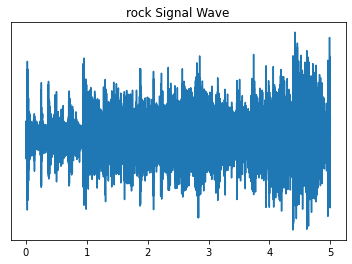

In [ ]:
for i,genre in enumerate(genres):
    t = str(random.randint(0,100))
    t = t.rjust(5, '0')
    genre_path = f'{music_library}/{genre}/{genre}.{t}.wav'
    y,sr=librosa.load(genre_path,duration=5.0,sr=None,)
    time=np.linspace(0,len(y)/sr,num=len(y))
    plt.figure(i+1)
    plt.title(genre+" Signal Wave")
    plt.yticks(ticks=[])
    plt.plot(time,y)
    format = 'png'
    name = f'{destination}/time_domain/{genre}_{t}.{format}'
    plt.savefig(name, format=format,quality=95,dpi=200)
    plt.show()

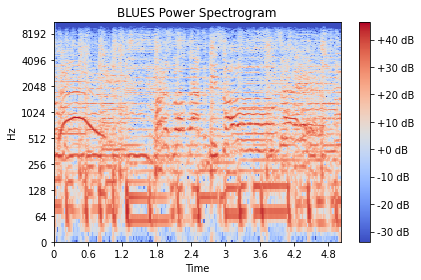

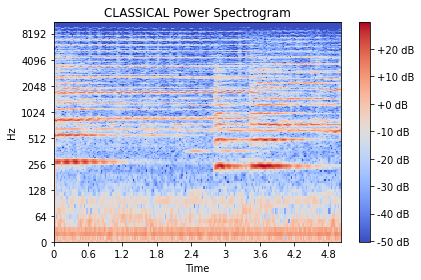

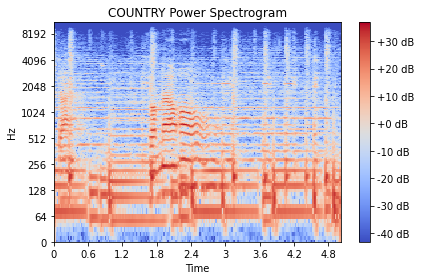

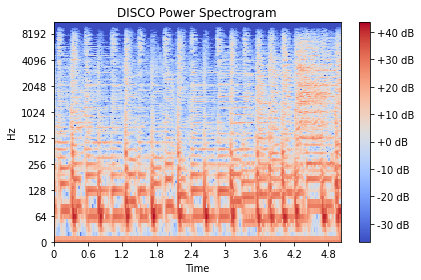

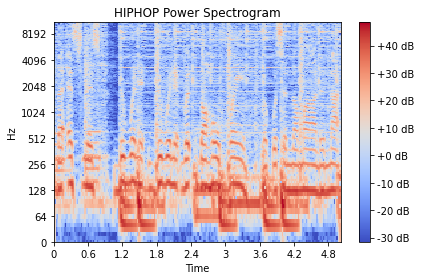

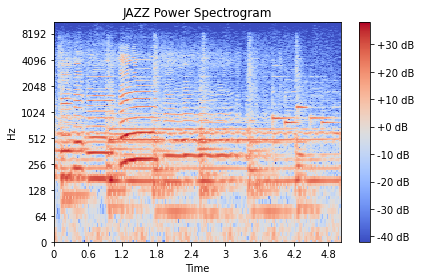

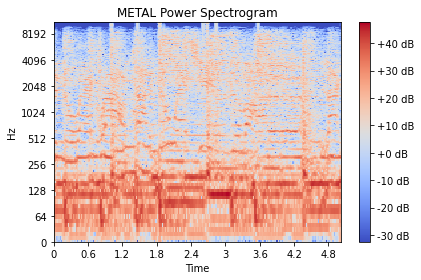

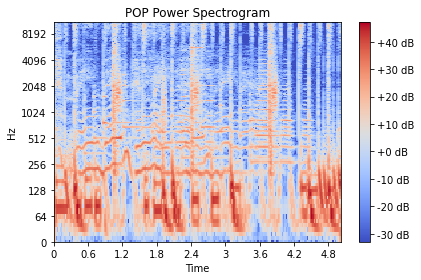

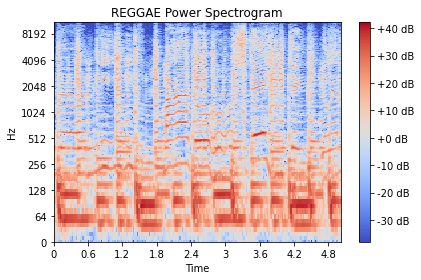

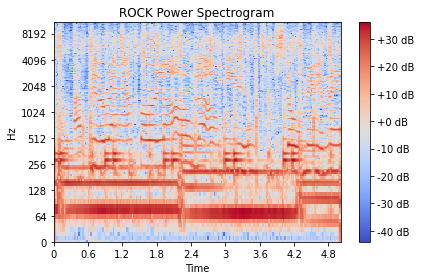

In [ ]:
for i,genre in enumerate(genres):
    t = str(random.randint(0,100))
    t = t.rjust(5, '0')
    genre_path = f'{music_library}/{genre}/{genre}.{t}.wav'
    y,sr=  librosa.load(genre_path,duration=5.0,sr=None,)
    librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(y)),ref=1.0),y_axis='log', x_axis='time')
    plt.title(genre.upper()+" Power Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    name = f'{destination}/power_spectrograms/{genre}_{t}.{format}'
    plt.savefig(name, format=format,quality=95,dpi=200)
    plt.show()

### split a song into multiple songs

In [ ]:
# split a song into multiple songs
from pydub import AudioSegment
newSong = 'newSong'
i = 0
for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join(f'{destination}/data',f"{g}")):
    song  =  os.path.join(f'{destination}/data/{g}',f'{filename}')
    j = j+1
    for w in range(0,5):
      i = i+1
      #print(i)
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'{destination}/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock


 ### Convert audio to melspectograms

In [ ]:
list_files(destination + '/audio3sec')

audio3sec/
    0
    blues/
        500
    classical/
        500
    country/
        500
    disco/
        500
    hiphop/
        500
    jazz/
        500
    metal/
        500
    pop/
        500
    reggae/
        500
    rock/
        500


In [ ]:
#!pip install "librosa==0.6.0"
print(librosa.__version__)
k =0 
for g in genres:
  j = 0
  print(g)
  print("Number of files in directory: ", len(os.listdir(os.path.join(destination + '/audio3sec',f"{g}"))))
  files = sorted(os.listdir(os.path.join(destination + '/audio3sec',f"{g}")))
  for filename in files:
    song  =  os.path.join(f'{destination}/audio3sec/{g}',f'{filename}')
    j = j+1
    print(f'Processing this song {filename}')
    start = time.time()
    y,sr = librosa.load(song,duration=3)
    #print(sr)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'{destination}/spectrograms3sec/{g}/{g+str(j)}.png')
    end = time.time()
    # total time taken
    print(f"Processing this song {filename} completed in {end - start}") 
    k = k + 1
print (k)

In [ ]:
directory = "/content/gdrive/My Drive/spectrograms3sec/train/"
for g in genres:
  filenames = os.listdir(os.path.join(directory,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:100]

  for f in test_files:

    shutil.move(directory + f"{g}"+ "/" + f,"/content/gdrive/My Drive/spectrograms3sec/test/" + f"{g}")


KeyboardInterrupt: ignored

In [ ]:
train_dir = "/content/gdrive/My Drive/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(288,432),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/gdrive/My Drive/spectrograms3sec/test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(288,432),color_mode='rgba',class_mode='categorical',batch_size=128)


Found 7964 images belonging to 9 classes.
Found 968 images belonging to 9 classes.


In [ ]:
def GenreModel(input_shape = (288,432,4),classes=9):
  np.random.seed(9)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(1,1),kernel_initializer = glorot_uniform(seed=9))(X_input)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)
  
  X = Conv2D(32,kernel_size=(3,3),strides = (1,1),kernel_initializer = glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64,kernel_size=(3,3),strides=(1,1),kernel_initializer=glorot_uniform(seed=9))(X)
  X = BatchNormalization(axis=-1)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((2,2))(X)

  
  X = Flatten()(X)

  X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=9))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model


In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = GenreModel(input_shape=(288,432,4),classes=9)
opt = Adam(learning_rate=0.00005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 288, 432, 4)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 286, 430, 8)       296       
_________________________________________________________________
batch_normalization_12 (Batc (None, 286, 430, 8)       32        
_________________________________________________________________
activation_12 (Activation)   (None, 286, 430, 8)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 143, 215, 8)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 141, 213, 16)      1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 141, 213, 16)      6

In [ ]:
model.fit_generator(train_generator,epochs=40,validation_data=vali_generator)


Epoch 1/40


/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 36 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/63 [..............................] - ETA: 1:22:33 - loss: 3.3061 - accuracy: 0.1484 - get_f1: 0.0544

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 15 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/63 [..............................] - ETA: 1:09:00 - loss: 3.0416 - accuracy: 0.1641 - get_f1: 0.0348

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 47 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/63 [>.............................] - ETA: 1:04:01 - loss: 2.7761 - accuracy: 0.1849 - get_f1: 0.0232

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)


 4/63 [>.............................] - ETA: 1:00:26 - loss: 2.5985 - accuracy: 0.1992 - get_f1: 0.0174

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 41 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/63 [=>............................] - ETA: 57:47 - loss: 2.4775 - accuracy: 0.2016 - get_f1: 0.0139  

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 61 could not be retrieved. It could be because a worker has died.
  UserWarning)


 6/63 [=>............................] - ETA: 55:58 - loss: 2.4085 - accuracy: 0.1953 - get_f1: 0.0141

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)


 7/63 [==>...........................] - ETA: 54:15 - loss: 2.3599 - accuracy: 0.1931 - get_f1: 0.0200

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


 8/63 [==>...........................] - ETA: 52:43 - loss: 2.3027 - accuracy: 0.1992 - get_f1: 0.0299

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)


 9/63 [===>..........................] - ETA: 51:20 - loss: 2.2509 - accuracy: 0.2049 - get_f1: 0.0383

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 55 could not be retrieved. It could be because a worker has died.
  UserWarning)


10/63 [===>..........................] - ETA: 50:04 - loss: 2.1988 - accuracy: 0.2148 - get_f1: 0.0454

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 27 could not be retrieved. It could be because a worker has died.
  UserWarning)


11/63 [====>.........................] - ETA: 48:55 - loss: 2.1538 - accuracy: 0.2230 - get_f1: 0.0534

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 20 could not be retrieved. It could be because a worker has died.
  UserWarning)


12/63 [====>.........................] - ETA: 47:56 - loss: 2.1141 - accuracy: 0.2272 - get_f1: 0.0651

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


13/63 [=====>........................] - ETA: 46:54 - loss: 2.0767 - accuracy: 0.2332 - get_f1: 0.0739

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 1 could not be retrieved. It could be because a worker has died.
  UserWarning)


14/63 [=====>........................] - ETA: 45:52 - loss: 2.0555 - accuracy: 0.2321 - get_f1: 0.0770

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


15/63 [======>.......................] - ETA: 44:47 - loss: 2.0310 - accuracy: 0.2354 - get_f1: 0.0834

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 31 could not be retrieved. It could be because a worker has died.
  UserWarning)


16/63 [======>.......................] - ETA: 43:44 - loss: 2.0039 - accuracy: 0.2373 - get_f1: 0.0952

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 51 could not be retrieved. It could be because a worker has died.
  UserWarning)


17/63 [=======>......................] - ETA: 42:43 - loss: 1.9815 - accuracy: 0.2408 - get_f1: 0.1043

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 52 could not be retrieved. It could be because a worker has died.
  UserWarning)


18/63 [=======>......................] - ETA: 41:39 - loss: 1.9563 - accuracy: 0.2478 - get_f1: 0.1112

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 19 could not be retrieved. It could be because a worker has died.
  UserWarning)


19/63 [========>.....................] - ETA: 40:38 - loss: 1.9341 - accuracy: 0.2578 - get_f1: 0.1169

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 13 could not be retrieved. It could be because a worker has died.
  UserWarning)


21/63 [=========>....................] - ETA: 37:01 - loss: 1.8928 - accuracy: 0.2658 - get_f1: 0.1327

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


22/63 [=========>....................] - ETA: 36:28 - loss: 1.8754 - accuracy: 0.2714 - get_f1: 0.1409

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


23/63 [=========>....................] - ETA: 35:35 - loss: 1.8597 - accuracy: 0.2736 - get_f1: 0.1455

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 44 could not be retrieved. It could be because a worker has died.
  UserWarning)


24/63 [==========>...................] - ETA: 34:46 - loss: 1.8420 - accuracy: 0.2786 - get_f1: 0.1546

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 42 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/63 [==========>...................] - ETA: 33:54 - loss: 1.8225 - accuracy: 0.2877 - get_f1: 0.1636

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 53 could not be retrieved. It could be because a worker has died.
  UserWarning)


26/63 [===========>..................] - ETA: 33:00 - loss: 1.8135 - accuracy: 0.2915 - get_f1: 0.1679

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


27/63 [===========>..................] - ETA: 32:09 - loss: 1.7969 - accuracy: 0.2974 - get_f1: 0.1749

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 30 could not be retrieved. It could be because a worker has died.
  UserWarning)


28/63 [============>.................] - ETA: 31:17 - loss: 1.7841 - accuracy: 0.3014 - get_f1: 0.1798

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 10 could not be retrieved. It could be because a worker has died.
  UserWarning)


29/63 [============>.................] - ETA: 30:25 - loss: 1.7753 - accuracy: 0.3037 - get_f1: 0.1814

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


30/63 [=============>................] - ETA: 29:32 - loss: 1.7664 - accuracy: 0.3061 - get_f1: 0.1819

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 22 could not be retrieved. It could be because a worker has died.
  UserWarning)


31/63 [=============>................] - ETA: 28:37 - loss: 1.7572 - accuracy: 0.3087 - get_f1: 0.1857

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 43 could not be retrieved. It could be because a worker has died.
  UserWarning)


32/63 [==============>...............] - ETA: 27:44 - loss: 1.7463 - accuracy: 0.3136 - get_f1: 0.1890

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


33/63 [==============>...............] - ETA: 26:52 - loss: 1.7353 - accuracy: 0.3191 - get_f1: 0.1948

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 34 could not be retrieved. It could be because a worker has died.
  UserWarning)


34/63 [===============>..............] - ETA: 25:57 - loss: 1.7288 - accuracy: 0.3213 - get_f1: 0.1970

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 49 could not be retrieved. It could be because a worker has died.
  UserWarning)


35/63 [===============>..............] - ETA: 25:05 - loss: 1.7216 - accuracy: 0.3233 - get_f1: 0.1996

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 35 could not be retrieved. It could be because a worker has died.
  UserWarning)


36/63 [================>.............] - ETA: 24:11 - loss: 1.7139 - accuracy: 0.3256 - get_f1: 0.2025

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 33 could not be retrieved. It could be because a worker has died.
  UserWarning)


37/63 [================>.............] - ETA: 23:18 - loss: 1.7030 - accuracy: 0.3294 - get_f1: 0.2072

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 23 could not be retrieved. It could be because a worker has died.
  UserWarning)


38/63 [=================>............] - ETA: 22:25 - loss: 1.6966 - accuracy: 0.3319 - get_f1: 0.2096

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 60 could not be retrieved. It could be because a worker has died.
  UserWarning)


39/63 [=================>............] - ETA: 21:33 - loss: 1.6877 - accuracy: 0.3336 - get_f1: 0.2127

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 32 could not be retrieved. It could be because a worker has died.
  UserWarning)


40/63 [==================>...........] - ETA: 20:40 - loss: 1.6792 - accuracy: 0.3375 - get_f1: 0.2163

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 50 could not be retrieved. It could be because a worker has died.
  UserWarning)


41/63 [==================>...........] - ETA: 19:45 - loss: 1.6689 - accuracy: 0.3411 - get_f1: 0.2209

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


42/63 [===================>..........] - ETA: 18:51 - loss: 1.6606 - accuracy: 0.3438 - get_f1: 0.2242

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 28 could not be retrieved. It could be because a worker has died.
  UserWarning)


43/63 [===================>..........] - ETA: 17:57 - loss: 1.6551 - accuracy: 0.3444 - get_f1: 0.2261

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 39 could not be retrieved. It could be because a worker has died.
  UserWarning)


44/63 [===================>..........] - ETA: 17:04 - loss: 1.6459 - accuracy: 0.3469 - get_f1: 0.2295

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 57 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/63 [====================>.........] - ETA: 16:11 - loss: 1.6411 - accuracy: 0.3472 - get_f1: 0.2311

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


46/63 [====================>.........] - ETA: 15:17 - loss: 1.6358 - accuracy: 0.3487 - get_f1: 0.2321

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


47/63 [=====================>........] - ETA: 14:23 - loss: 1.6300 - accuracy: 0.3519 - get_f1: 0.2343

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 46 could not be retrieved. It could be because a worker has died.
  UserWarning)


48/63 [=====================>........] - ETA: 13:29 - loss: 1.6247 - accuracy: 0.3536 - get_f1: 0.2371

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)


49/63 [======================>.......] - ETA: 12:36 - loss: 1.6176 - accuracy: 0.3563 - get_f1: 0.2395

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 38 could not be retrieved. It could be because a worker has died.
  UserWarning)


50/63 [======================>.......] - ETA: 11:41 - loss: 1.6112 - accuracy: 0.3603 - get_f1: 0.2409

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 37 could not be retrieved. It could be because a worker has died.
  UserWarning)


51/63 [=======================>......] - ETA: 10:48 - loss: 1.6066 - accuracy: 0.3619 - get_f1: 0.2408

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 59 could not be retrieved. It could be because a worker has died.
  UserWarning)


52/63 [=======================>......] - ETA: 9:54 - loss: 1.5991 - accuracy: 0.3652 - get_f1: 0.2424 

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


53/63 [========================>.....] - ETA: 9:00 - loss: 1.5934 - accuracy: 0.3689 - get_f1: 0.2453

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 56 could not be retrieved. It could be because a worker has died.
  UserWarning)


54/63 [========================>.....] - ETA: 8:06 - loss: 1.5883 - accuracy: 0.3713 - get_f1: 0.2484

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


55/63 [=========================>....] - ETA: 7:12 - loss: 1.5821 - accuracy: 0.3742 - get_f1: 0.2510

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 17 could not be retrieved. It could be because a worker has died.
  UserWarning)


56/63 [=========================>....] - ETA: 6:18 - loss: 1.5767 - accuracy: 0.3772 - get_f1: 0.2534

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 25 could not be retrieved. It could be because a worker has died.
  UserWarning)


57/63 [==========================>...] - ETA: 5:24 - loss: 1.5710 - accuracy: 0.3799 - get_f1: 0.2573

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 40 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/63 [==========================>...] - ETA: 4:30 - loss: 1.5668 - accuracy: 0.3822 - get_f1: 0.2595

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 29 could not be retrieved. It could be because a worker has died.
  UserWarning)


59/63 [===========================>..] - ETA: 3:36 - loss: 1.5625 - accuracy: 0.3831 - get_f1: 0.2624

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 58 could not be retrieved. It could be because a worker has died.
  UserWarning)


60/63 [===========================>..] - ETA: 2:42 - loss: 1.5589 - accuracy: 0.3840 - get_f1: 0.2645

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 45 could not be retrieved. It could be because a worker has died.
  UserWarning)


61/63 [============================>.] - ETA: 1:48 - loss: 1.5546 - accuracy: 0.3856 - get_f1: 0.2667

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


62/63 [============================>.] - ETA: 54s - loss: 1.5501 - accuracy: 0.3864 - get_f1: 0.2695 

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 48 could not be retrieved. It could be because a worker has died.
  UserWarning)


63/63 [==============================] - 3462s 55s/step - loss: 1.5479 - accuracy: 0.3872 - get_f1: 0.2701 - val_loss: 2.1692 - val_accuracy: 0.1736 - val_get_f1: 0.0000e+00
Epoch 2/40
63/63 [==============================] - 961s 15s/step - loss: 1.1776 - accuracy: 0.5578 - get_f1: 0.4343 - val_loss: 2.0242 - val_accuracy: 0.3533 - val_get_f1: 0.0000e+00
Epoch 3/40
63/63 [==============================] - 965s 15s/step - loss: 1.0353 - accuracy: 0.6177 - get_f1: 0.5270 - val_loss: 1.9596 - val_accuracy: 0.4545 - val_get_f1: 0.0818
Epoch 4/40
63/63 [==============================] - 973s 15s/step - loss: 0.9573 - accuracy: 0.6467 - get_f1: 0.5836 - val_loss: 1.7302 - val_accuracy: 0.4897 - val_get_f1: 0.3760
Epoch 5/40
63/63 [==============================] - 967s 15s/step - loss: 0.8915 - accuracy: 0.6743 - get_f1: 0.6300 - val_loss: 1.3075 - val_accuracy: 0.5279 - val_get_f1: 0.5017
Epoch 6/40
63/63 [==============================] - 966s 15s/step - loss: 0.8327 - accuracy: 0.7038 - 

In [ ]:

preds = model.evaluate(x=X_test,y=Y_test)
print(preds[1])
print(preds[2])



99/99 [==============================] - 1s 5ms/step
0.4343434274196625
0.3583858609199524
